<a href="https://colab.research.google.com/github/JonasHeymans/appartementen/blob/master/preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv('all.csv', index_col='Unnamed: 0')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (29,37,58,92,116,120,136,139,140,141,144,146,150,152,154,162,169,170,172,173,174,175,177,180,181,182,183,184,186,187,188,189,190,191,193,194,195,196,197,198,200,201,203,205,206,207,209,210,211,212,213) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Dropping street and housenumber for now, but might be intereting later use it, eg via a graph library

df = df.drop(['property.location.box', 'property.location.street',
              'property.location.latitude', 'property.location.longitude',
              'property.location.locality', 'property.location.number',
              'Address',], axis=1)

df = df.drop(columns=['flags.main','customerLogoUrl','customerName','media.pictures',
                      'flags.secondary','Price','property.title','publication.size',
                      'publication.visualisationOption','External reference',
                      'Reference number of the EPC report','Website', 'Available as of'], axis =1)

In [4]:
# Removing outliers
df = df[df['Floor :'] < 30]

# Geen openbare verkopen waar we moeten bieden of verkopen op lijfrente.
df = df[df['price.label'] == 'Price']

# Geen slaapkamers vermeld is nogal raar.

df = df[df['property.bedroomCount'] > 0]

binary_cols = ['Double glazing','Armored door','Elevator','Basement',
             'Intercom','Planning permission obtained', 'Type of building']
df[binary_cols] =df[binary_cols].replace('Yes', 1).replace('No',0)


# Striping things like 'm²square meters' from numerical columns and
# converting them to float

numerical_cols = ['CO² emission', 'Living area','Living room surface',
            'Bedroom 1 surface','Bedroom 2 surface','Cadastral income',
            'E-level (primary energy consumption)','Terrace surface']

strippers = ['kg CO2/m²','kWh/m²kilowatt hour per square meters',
            'm²square meters','€']

for x in numerical_cols:
    for y in strippers:
        df[x] = df[x].str.strip(y).replace('Not specified',np.nan)
    df[x] = df[x].str.replace('.','').str.replace(',','.').replace('', np.nan)
    df[x] = df[x].astype(float)

# Dropping columns with duplicate information
to_drop = ['Floor','price.shortDisplayPrice','price.accessibilityPrice',
           'price.mainDisplayPrice', 'property.location.floor','Bedrooms','bedrooms','bedroom',
           'transaction.sale.price','bathroom']

df = df.drop(to_drop, axis=1)

In [5]:
for column in df.columns:
    if df[column].isnull().sum() > 0.8*len(df):
        df = df.drop(column, axis=1)
    elif len(df[column].unique()) == 1:
        df = df.drop(column, axis=1)

In [6]:
nominal_cols = ['property.subtype', 'Flood zone type', 'Heating type','Kitchen type',
            'Building condition', 'Type of building','As built plan','property.location.postalCode'
            ]

df = pd.get_dummies(data= df, columns=nominal_cols)

In [7]:
# Ordinal encoding
ordinal_cols= ['Energy class']
scale_mapper = {'A':1,
                'B':2,
                'C':3,
                'D':4,
                'E':5,
                'F':6,
                'Not specified': np.nan
                }

df[ordinal_cols] = df[ordinal_cols].replace(scale_mapper)


In [8]:
# def remove_outlier(df, col):
#   q1 = df[col].quantile(0.25)
#   q3 = df[col].quantile(0.75)
#   iqr = q3 - q1
#   lower_bound  = q1 - (1.5  * iqr)
#   upper_bound = q3 + (1.5 * iqr)
#   out_df = df.loc[(df[col] > lower_bound) & (df[col] < upper_bound)]
#   return out_df
# df = remove_outlier(df,"price.mainValue")
#
# threshold = len(df) * .75
# df.dropna(thresh = threshold, axis = 1, inplace = True)
#

In [9]:
# Making a dict of all cols with missing values
missing = {col: df[col].isnull().sum() for col in df.columns if df[col].isnull().sum()  != 0}
missing

{'Armored door': 1396,
 'Basement': 1516,
 'Bathrooms': 217,
 'Bedroom 1 surface': 1173,
 'Bedroom 2 surface': 1351,
 'Cadastral income': 1206,
 'Construction year': 710,
 'Covered parking spaces': 1546,
 'Double glazing': 633,
 'E-level (primary energy consumption)': 607,
 'Elevator': 911,
 'Energy class': 699,
 'Facades': 774,
 'Intercom': 1342,
 'Living area': 157,
 'Living room surface': 1197,
 'Number of floors': 867,
 'Planning permission obtained': 809,
 'Terrace surface': 996,
 'Toilets': 542,
 'm²square meterslivable space': 137,
 'property.netHabitableSurface': 137}

In [10]:
from sklearn.impute import  MissingIndicator
missing_bin = [x for x in missing.keys() if x in binary_cols]
imp = MissingIndicator()
df[missing_bin]= imp.fit_transform(df[missing_bin])

from sklearn.impute import SimpleImputer
missing_ord= [x for x in missing.keys() if x in ordinal_cols]
imp = SimpleImputer(strategy='median')
df[missing_ord]= imp.fit_transform(df[missing_ord])

missing_num = [x for x in missing.keys() if df[x].isnull().sum() != 0]

from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=2)
df[missing_num] = imputer.fit_transform(df[missing_num])



In [11]:
from sklearn.model_selection import train_test_split
features =  list(df.drop(columns=['price.mainValue','id'],axis=1))
X = df[features]
y = df['price.mainValue']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [13]:
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
dummy_median = DummyRegressor(strategy='mean')
dummy_regressor = dummy_median.fit(X_train,y_train)
dummy_predicts = dummy_regressor.predict(X_test)
print("Model Accuracy:", dummy_regressor.score(X_test,y_test)*100)
print('$',mean_absolute_error(y_test,dummy_predicts))

Model Accuracy: -0.594864354995539
$ 129701.84278189455


In [14]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
models = [
          DecisionTreeRegressor(criterion='mse',max_depth=11,random_state=100),
          GradientBoostingRegressor(n_estimators=200,max_depth=12, verbose=2),
            RandomForestRegressor(min_samples_leaf =1, n_estimators=100,criterion='mse',max_depth=20,random_state=100,verbose=2)]
learning_mods = pd.DataFrame()
temp = {}

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=11,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=100, splitter='best')
score on training 0.9785767302263569
r2 score 0.7315195704251398 

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=12,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='deprecated',
                    

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


r2 score 0.7772379931008161 



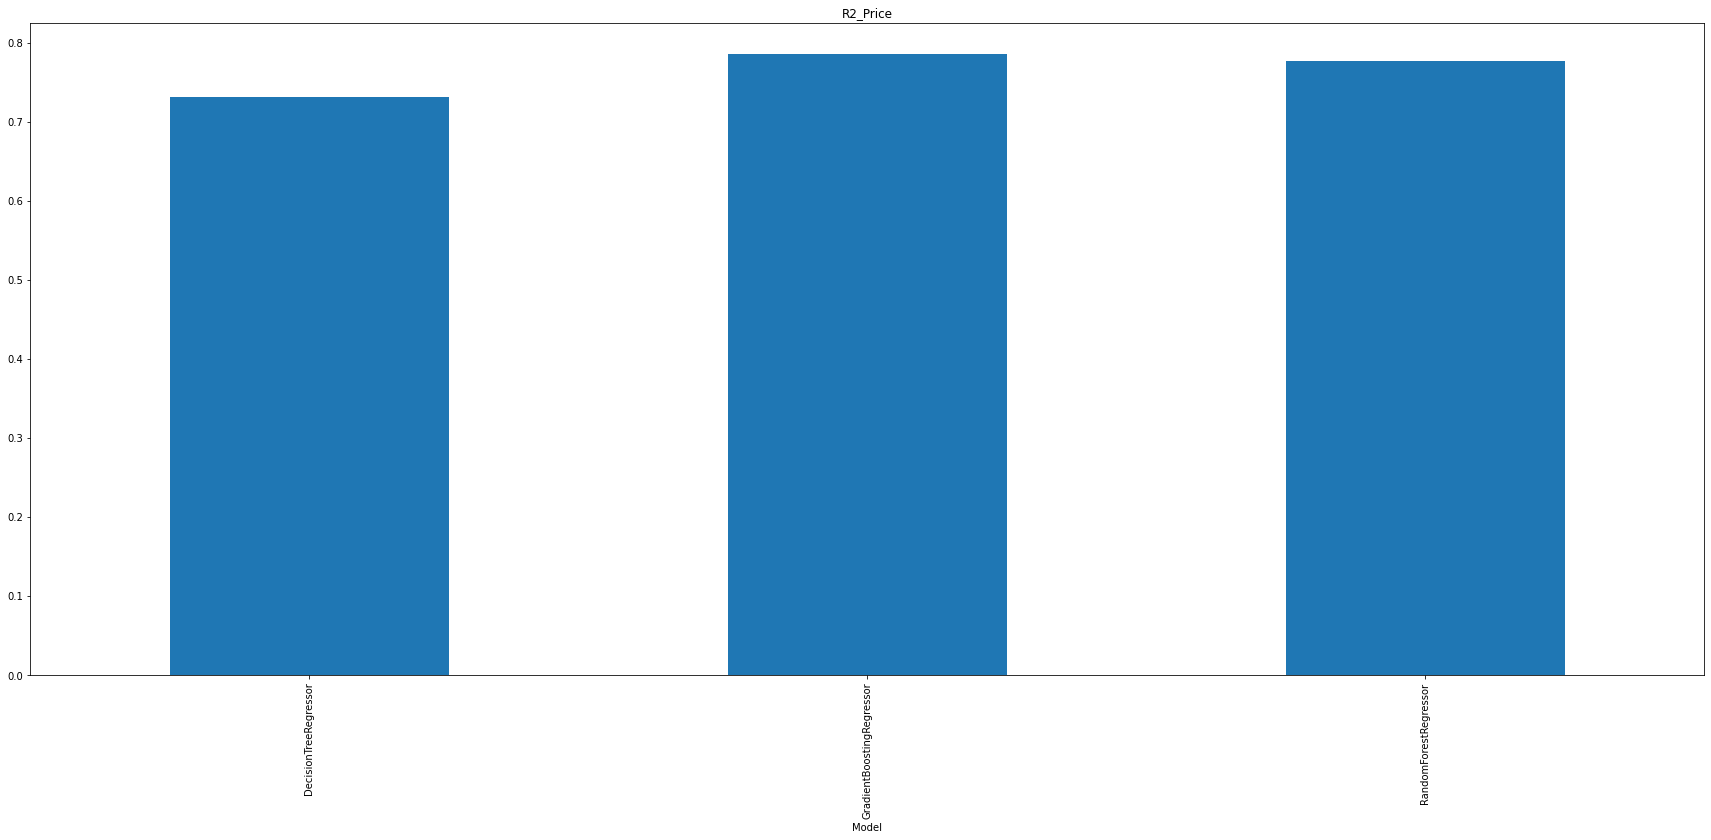

In [15]:
#run through models
for model in models:
    print(model)
    m = str(model)
    temp['Model'] = m[:m.index('(')]
    model.fit(X_train, y_train)
    temp['R2_Price'] = r2_score(y_test, model.predict(X_test))
    print('score on training',model.score(X_train, y_train))
    print('r2 score',r2_score(y_test, model.predict(X_test)),'\n')
    learning_mods = learning_mods.append([temp])
learning_mods.set_index('Model', inplace=True)

fig, axes = plt.subplots(ncols=1, figsize=(30, 12))
learning_mods.R2_Price.plot(ax=axes, kind='bar', title='R2_Price')
plt.show()

In [16]:
regressionTree_imp = model.feature_importances_
# plt.figure(figsize=(16,6))
# plt.yscale('log',nonposy='clip')
# plt.bar(range(len(regressionTree_imp)),regressionTree_imp,align='center')
# plt.xticks(range(len(regressionTree_imp)),features,rotation='vertical')
# plt.title('Feature Importance')
# plt.ylabel('Importance')
# plt.show()

In [17]:
data_tuples = list(zip(features,regressionTree_imp.tolist()))
features_importance = pd.DataFrame(data_tuples, columns=['Feature','Value'])

In [18]:
print(len(features_importance))
unimportant_features = features_importance[features_importance['Value'] < .001]
features_importance = features_importance[features_importance['Value'] > .001]
print(len(features_importance))

103
36


In [19]:
features_importance = features_importance.sort_values(by=['Value'], ascending=False)
pd.set_option('display.float_format', lambda x: '%.1000f' % x)
features_importance

,Feature,Value
14,m²square meterslivable space,0.343512974691015438022390071637346409261226654...
1,property.netHabitableSurface,0.307328348484664559681078799258102662861347198...
10,Living area,0.080119250345213555153378592876833863556385040...
60,property.location.postalCode_2000,0.034726997245879610842766993528130115009844303...
5,Construction year,0.026203550374481621859645841254859988112002611...
11,Living room surface,0.018057210766997545958734150417512864805757999...
4,Bathrooms,0.015004680232628469713218599679294129600748419...
20,Terrace surface,0.013038720665918188817977707572026702109724283...
15,Cadastral income,0.012988897002688877882481399694825086044147610...
2,Unnamed: 0.1,0.011619739245460685220234786640958191128447651...


In [20]:
data_tuples = list(zip(y_test,model.predict(X_test)))
features_importance = pd.DataFrame(data_tuples, columns=['Echte Waarde','Voorspelling'])
features_importance['Voorspelling'] = features_importance['Voorspelling'].astype(float)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [21]:
features_importance.astype(int)

,Echte Waarde,Voorspelling
0,149000,189024
1,150000,199890
2,379000,509292
3,165000,212689
4,279000,195849
...,...,...
402,199900,194270
403,230000,722390
404,150000,275399
405,285500,879011


In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'bootstrap': [True],
    'max_depth': range(1,100,10),
    'max_features': range(1,30,5),
    'min_samples_leaf': range(1,25,5),
    'min_samples_split': range(1,20,5),
    'n_estimators': range(100,1500,250)
}
rf = RandomForestRegressor()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(X, y)

Fitting 3 folds for each of 7200 candidates, totalling 21600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed: 16.2min
[Parallel(n_jobs=-1)]: Done 1981 tasks      | elapsed: 22.6min
[Parallel(n_jobs=-1)]: Done 2588 tasks      | elapsed: 30.1min
[Parallel(n_jobs=-1)]: Done 3277 tasks      | elapsed: 41.6min
[Parallel(n_jobs=-1)]: Done 4046 tasks      | elapsed: 59.7min
[Parallel(n_jobs=-1)]: Done 4897 tasks      | elapsed: 74.9min
[Parallel(n_jobs=-1)]: Done 5828 tasks      | elapsed: 94.2min
[Parallel(n_jobs=-1)]: Done 6841 tasks      | elapsed: 115.9min
[Parallel(n_jobs=-1)]: Done 7934 tasks      | elapsed: 136.8min
[Parallel(n_jobs=-1)]: Done 9109 tasks      

In [ ]:

print("-grid.best_score_ {}".format(grid_search.best_score_))
print("grid.best_params_ {}".format(grid_search.best_params_))
print("grid.best_estimator_ {}".format(grid_search.best_estimator_))  